In [1]:
import numpy as np
from matplotlib import pyplot as plt

def exp_mud(mu, sigma, M, lam_ref):
	res = mu - lam_ref
	op = np.dot(sigma, np.dot(M.T, M) )
	wt = np.dot(M, np.dot(sigma, M.T) )
	P = op/wt
	return mu - np.dot(P, res)

K = np.array([[2, 1]])
qnum = 6
J = np.array([[0.9*np.sin(theta), np.cos(theta)] for theta in np.linspace(0, np.pi, qnum+1)[0:-1]]).reshape(qnum,2)

skew = 1.2
K = np.array([[1, 0], [np.sqrt(skew**2 - 1), 1]])
sigma = np.array([[1, 0], [0, 1]])*0.5
lam = np.array([0.5, 0.5])

num_repeats = 20
num_initials = 5
color = ["b", "k", "r", "g", "c"]
for i in range(num_initials):
	mu_last = np.random.rand(2)
	mu = np.copy(mu_last)
	for it in range(qnum*num_repeats):
		M = np.array([J[it%qnum, :]])
		#M = np.array([[6.28/(np.random.randint(qnum)%qnum+1), 1]])
# 		M = np.array([K[it%2, :]])
		#if it%2:
		#	M = np.array([[0.7, 0.7]])
		#else:
		#	M = np.array([[0, 1]])


		mu = exp_mud(mu_last, sigma, M, lam)
# 		print(mu_last, M, mu)
		plt.plot([mu_last[0], mu[0]], [mu_last[1], mu[1]], c=color[i%5])
		mu_last = np.copy(mu)

#plt.plot([0, 1], [0, 1], alpha=0.5, c="k")
#plt.plot([0, 1], [1.5, -0.5], alpha=0.5, c="k")
# plotting window
delta = 0.01
original_domain = True
#plt.axis("equal")
# plt.plot()
angle = np.pi/2
JJ = (np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])@J.T).T
# JJ = (np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])@K.T).T
for i in range(qnum):
    try:
        plt.plot([0.5-JJ[i,0],0.5+JJ[i,0]], [0.5-JJ[i,1], 0.5+JJ[i,1]], c='k', ls=':')
    except:
        pass

if original_domain:
    plt.xlim([0, 1])
    plt.ylim([0, 1])
else:
    plt.xlim([0.5-delta, 0.5+delta])
    plt.ylim([0.5-delta, 0.5+delta])


plt.show()


<Figure size 640x480 with 1 Axes>

In [2]:
import sys

In [3]:
sys.path.append('/home/jovyan/work/mud-paper/figures')

In [4]:
import mud

In [5]:
def rotationMap(qnum = 10, orth=True):
    if orth:
        return np.array([[np.sin(theta), np.cos(theta)] for theta in np.linspace(0, np.pi, qnum+1)[0:-1]]).reshape(qnum,2)
    else:
        return np.array([[np.sin(theta), np.cos(theta)] for theta in np.linspace(0, np.pi, qnum+2)[1:-1]]).reshape(qnum,2)

In [6]:
numQoI = 10
A = rotationMap(numQoI, orth=True)
A = A.reshape(-1,2)
b = np.zeros((numQoI,1))
# A, b = A[np.array([2,6]),:].reshape(-1,2), b[np.array([2,6])].reshape(-1,1)
ref_param = np.array([0.5, 0.5]).reshape(-1,1)
y = A@ref_param + b
initial_mean = np.random.rand(2).reshape(-1,1)
tol = 0.1
initial_cov = np.eye(2)*mud.std_from_equipment(tol)

In [7]:
def performEpoch(A, b, y, initial_mean, initial_cov, data_cov=None, idx=None):
    dim_out = A.shape[0]
    mud_chain = []
    
    current_mean = initial_mean
    mud_chain.append(current_mean)
    if idx is None: idx = range(dim_out)
    for i in idx:
        _A = A[i,:].reshape(1,2)
        _b = b[i]
        _y = y[i]
        mud_chain.append(mud.mud_sol(_A, _b, _y, current_mean, initial_cov, data_cov=None))
        current_mean = mud_chain[-1]
    return mud_chain

def iterate(A, b, y, initial_mean, initial_cov, data_cov=None, num_epochs=1, idx=None):
    mud_chain = performEpoch(A, b, y, initial_mean, initial_cov, data_cov, idx)
    for k in range(1, num_epochs):
        mud_chain += performEpoch(A, b, y, mud_chain[-1], initial_cov, data_cov, idx)
    
    return mud_chain

def plotChain(mud_chain, ref_param, color='k'):
    num_steps = len(mud_chain)
    current_point = mud_chain[0]
    plt.scatter(current_point[0], current_point[1], c='b')
    for i in range(0,num_steps):
        next_point = mud_chain[i]
        points = np.hstack([current_point, next_point])
        plt.plot(points[0,:], points[1,:], c=color)
        current_point = next_point

    plt.ylim([0,1])
    plt.xlim([0,1])
#     plt.axis('off')
    plt.scatter(ref_param[0], ref_param[1], c='r')

In [8]:
mud_chain_test = performEpoch(A, b, y, initial_mean, initial_cov, data_cov=None)

In [9]:
import scipy as sp

In [10]:
def plot_contours(A,color='k'):
    numQoI = A.shape[0]
    AA = np.hstack([sp.linalg.null_space(A[i,:].reshape(1,-1)) for i in range(numQoI)]).T
    for i in range(numQoI):
        plt.plot([0.5-AA[i,0],0.5+AA[i,0]], [0.5-AA[i,1], 0.5+AA[i,1]], c=color, ls=':')

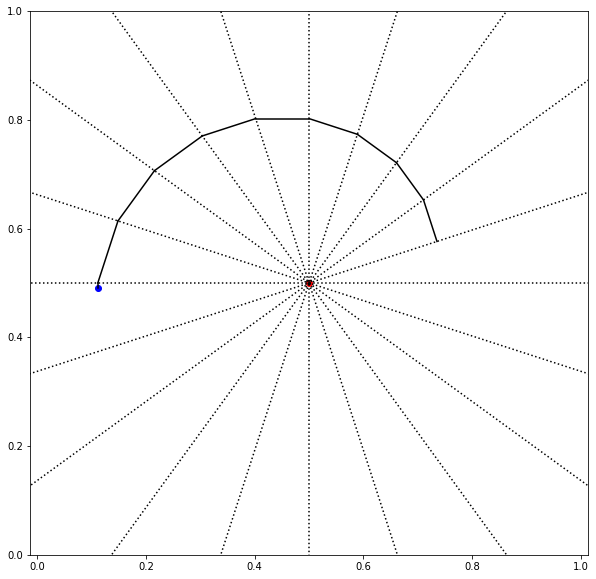

In [11]:
plt.figure(figsize=(10,10))
mud_chain = iterate(A, b, y, initial_mean, initial_cov, data_cov=None, num_epochs=1, idx=None)
plotChain(mud_chain, ref_param)
plot_contours(A)

plt.axis('equal')
# plt.ylim([0.25,0.75])
# plt.xlim([0.25,0.75])
plt.ylim([0,1])
plt.xlim([0,1])
plt.savefig(f'iterative/{numQoI}D-firstepoch.png')
plt.show()

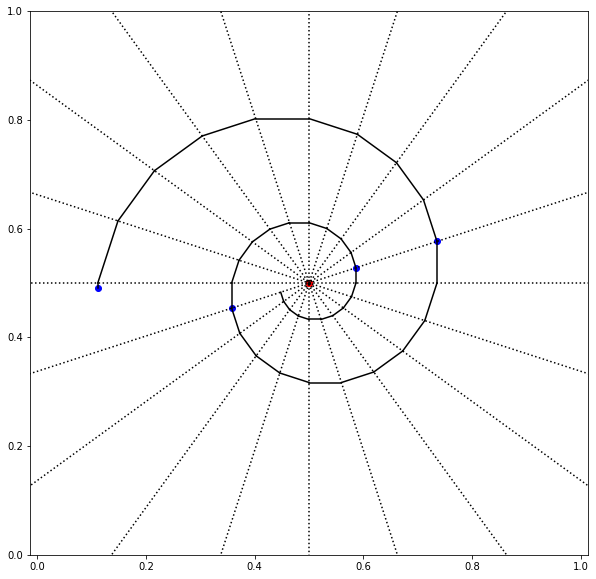

In [12]:
plt.figure(figsize=(10,10))
mud_chain = iterate(A, b, y, initial_mean, initial_cov, data_cov=None, num_epochs=1)
plotChain(mud_chain, ref_param)
for _ in range(3):
    mud_chain = iterate(A, b, y, mud_chain[-1], initial_cov, data_cov=None, num_epochs=1)
    plotChain(mud_chain, ref_param)
    
plot_contours(A)

plt.axis('equal')
# plt.ylim([0.25,0.75])
# plt.xlim([0.25,0.75])
plt.ylim([0,1])
plt.xlim([0,1])
plt.savefig(f'iterative/{numQoI}D-fewepochs.png')
plt.show()

# What if we picked out two of the ten rows?

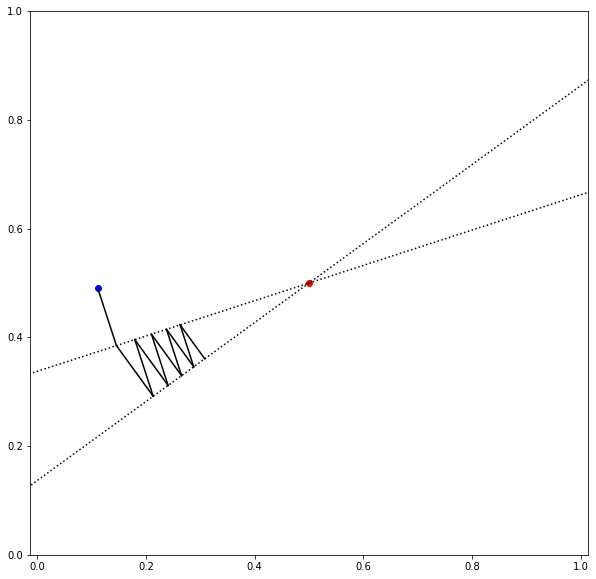

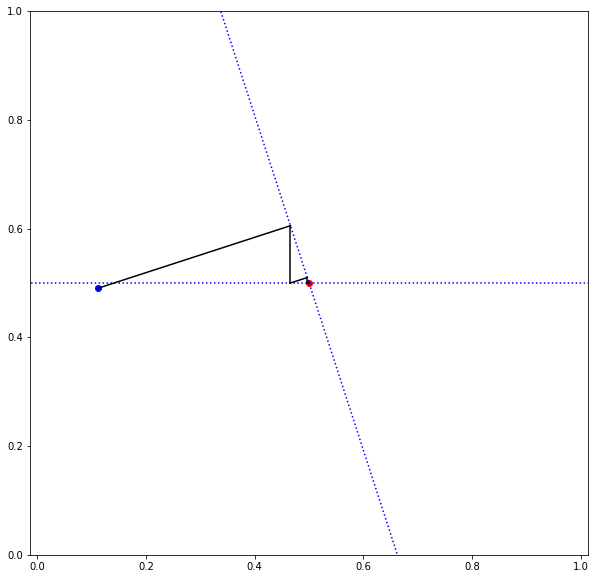

In [13]:
np.random.seed(21)
plt.figure(figsize=(10,10))
idx_choice = [np.random.randint(numQoI), np.random.randint(numQoI)]
mud_chain = iterate(A, b, y, initial_mean, initial_cov, data_cov=None, num_epochs=5, idx=idx_choice)
plot_contours(A[np.array(idx_choice),:])
plotChain(mud_chain,ref_param)

plt.axis('equal')
# plt.ylim([0.25,0.75])
# plt.xlim([0.25,0.75])
plt.ylim([0,1])
plt.xlim([0,1])
plt.savefig(f'iterative/{numQoI}D-fewepochs-pair.png')
plt.show()


idx_choice = [np.random.randint(numQoI), np.random.randint(numQoI)]
plt.figure(figsize=(10,10))
mud_chain = iterate(A, b, y, initial_mean, initial_cov, data_cov=None, num_epochs=5, idx=idx_choice)
plot_contours(A[np.array(idx_choice),:],'b')
plotChain(mud_chain, ref_param)

plt.axis('equal')
# plt.ylim([0.25,0.75])
# plt.xlim([0.25,0.75])
plt.ylim([0,1])
plt.xlim([0,1])
plt.savefig(f'iterative/{numQoI}D-fewepochs-pair-alt.png')
plt.show()

# Picking orthogonal rows of A leads to immediate convergence

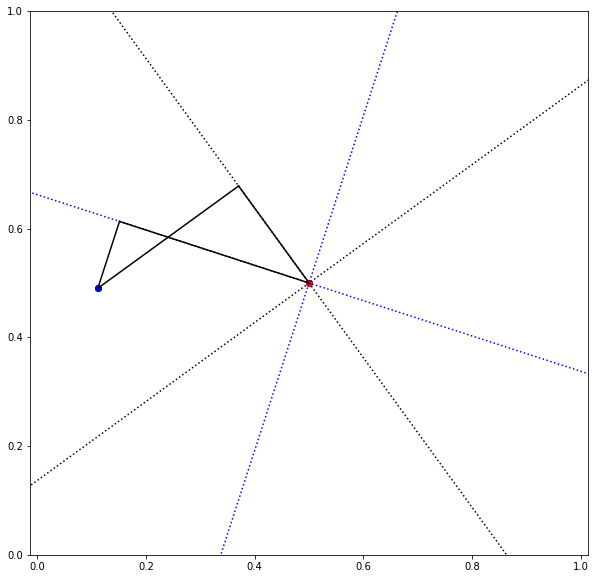

In [14]:
plt.figure(figsize=(10,10))
idx_choice = [3,8]
mud_chain = iterate(A, b, y, initial_mean, initial_cov, data_cov=None, num_epochs=5, idx=idx_choice)
plot_contours(A[np.array(idx_choice),:])
plotChain(mud_chain, ref_param)

idx_choice = [1,6]
mud_chain = iterate(A, b, y, initial_mean, initial_cov, data_cov=None, num_epochs=5, idx=idx_choice)
plot_contours(A[np.array(idx_choice),:], 'b')
plotChain(mud_chain, ref_param)

plt.axis('equal')
# plt.ylim([0.25,0.75])
# plt.xlim([0.25,0.75])
plt.ylim([0,1])
plt.xlim([0,1])
plt.savefig(f'iterative/{numQoI}D-firstepoch-pair-smart.png')
plt.show()

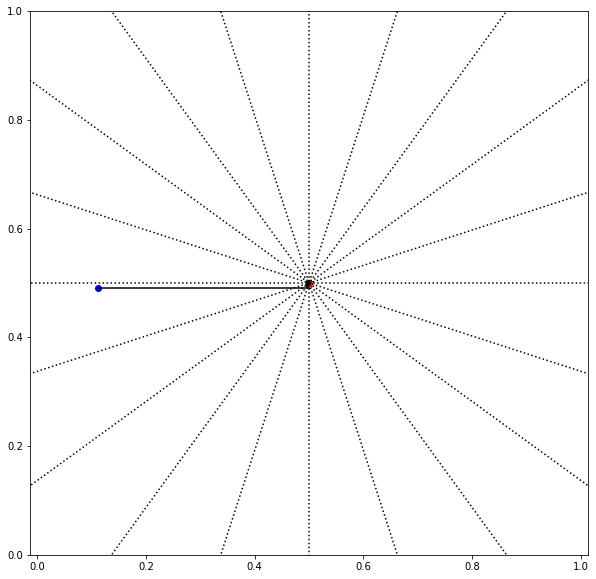

In [15]:
np.random.seed(12)
plt.figure(figsize=(10,10))
idx_choice = np.arange(numQoI)
np.random.shuffle(idx_choice)
mud_chain = iterate(A, b, y, initial_mean, initial_cov, data_cov=None, num_epochs=1, idx=idx_choice)
plot_contours(A[np.array(idx_choice),:])
plotChain(mud_chain, ref_param)

plt.axis('equal')
# plt.ylim([0.25,0.75])
# plt.xlim([0.25,0.75])
plt.ylim([0,1])
plt.xlim([0,1])
plt.savefig(f'iterative/{numQoI}D-firstepoch-rand.png')
plt.show()

---
# Quantifying the Impact of all of "this"

Let us be more formal and perform this experiment for the rotationally-defined $A$ for more choices of initial means.
We also want to experiment with several orderings of indices for our iteration.

In [16]:
num_trials = 20

# ordered
idx_choice = np.arange(numQoI)
mud_chains_from_ordered = []
for trial in range(num_trials):
    initial_mean = np.random.rand(2,1)
    mud_chain = iterate(A, b, y, initial_mean, initial_cov, data_cov=None, num_epochs=10, idx=idx_choice)
    mud_chains_from_ordered.append(mud_chain)

# some random ordering, multiple epochs
idx_choice = np.arange(numQoI)
np.random.shuffle(idx_choice)
mud_chains_from_shuffles = []
for trial in range(num_trials):
    initial_mean = np.random.rand(2,1)
    np.random.shuffle(idx_choice)
    mud_chain = iterate(A, b, y, initial_mean, initial_cov, data_cov=None, num_epochs=10, idx=idx_choice)
    mud_chains_from_shuffles.append(mud_chain)

# each epoch, order differently
idx_choice = list(np.arange(numQoI))*10
np.random.shuffle(idx_choice)
mud_chains_from_randoms = []
for trial in range(num_trials):
    initial_mean = np.random.rand(2,1)
    np.random.shuffle(idx_choice)
    mud_chain = iterate(A, b, y, initial_mean, initial_cov, data_cov=None, num_epochs=1, idx=idx_choice)
    mud_chains_from_randoms.append(mud_chain)

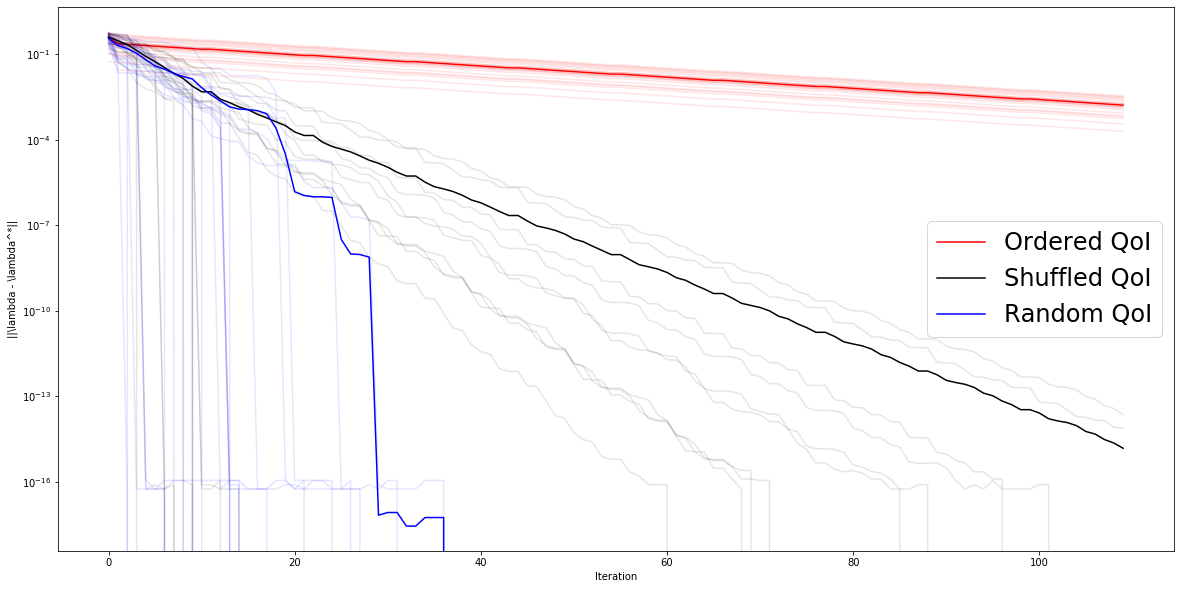

In [17]:
plt.figure(figsize=(20,10))
error = []
for mud_chain in mud_chains_from_ordered:
    approx_error = [np.linalg.norm(m - ref_param) for m in mud_chain]
    error.append(approx_error)
    plt.plot(approx_error, 'r', alpha=0.1)
plt.plot(np.mean(np.array(error),axis=0), 'r', label='Ordered QoI')

error = []
for mud_chain in mud_chains_from_shuffles:
    approx_error = [np.linalg.norm(m - ref_param) for m in mud_chain]
    error.append(approx_error)
    plt.plot(approx_error, 'k', alpha=0.1)
plt.plot(np.mean(np.array(error),axis=0), 'k', label='Shuffled QoI')


error = []
for mud_chain in mud_chains_from_randoms:
    approx_error = [np.linalg.norm(m - ref_param) for m in mud_chain]
    error.append(approx_error)
    plt.plot(approx_error, 'b', alpha=0.1)
plt.plot(np.mean(np.array(error),axis=0), 'b', label='Random QoI')

plt.legend(fontsize=24)
plt.yscale('log')
# plt.xscale('log')
plt.ylabel("||\lambda - \lambda^*||")
plt.xlabel("Iteration")
plt.savefig(f'iterative/{numQoI}D-convergence-comparison.png')
plt.show()